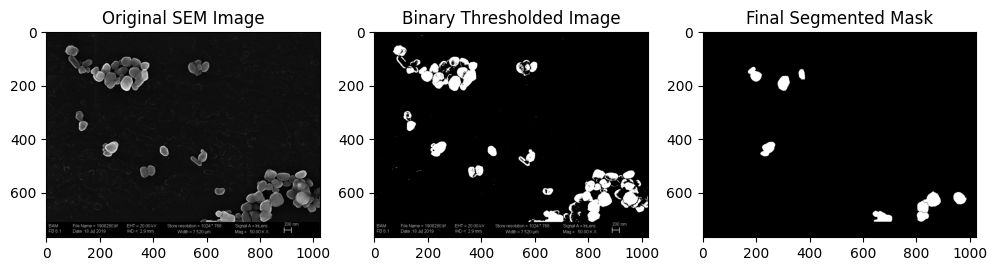

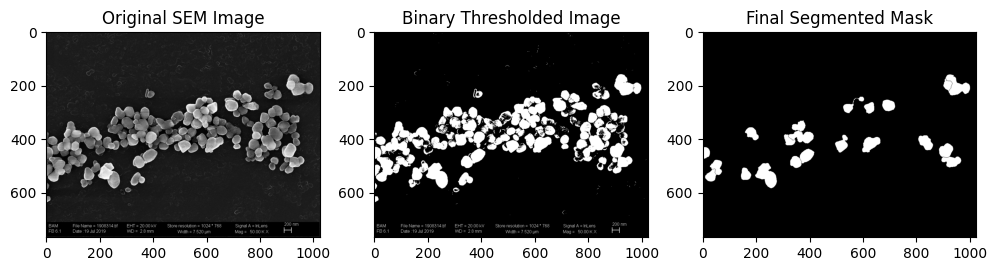

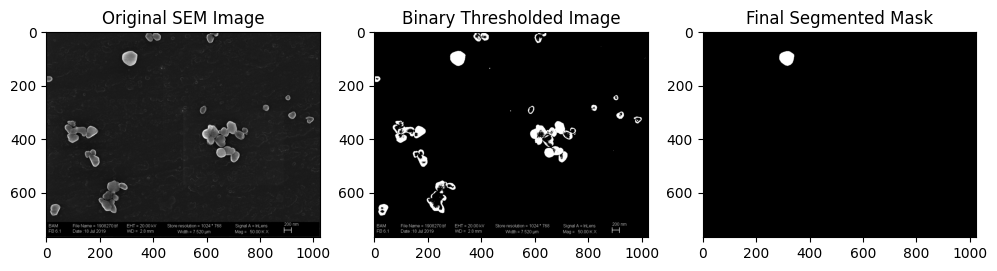

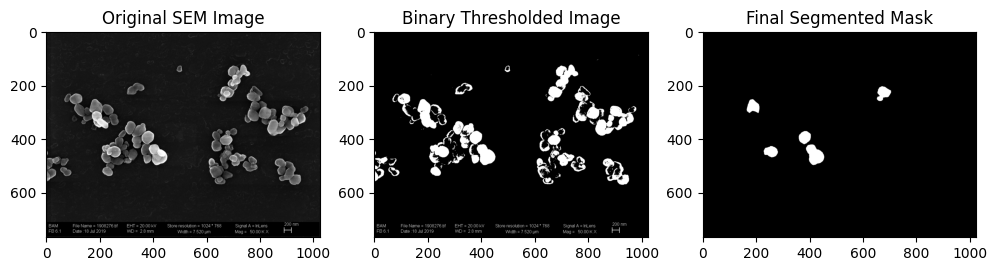

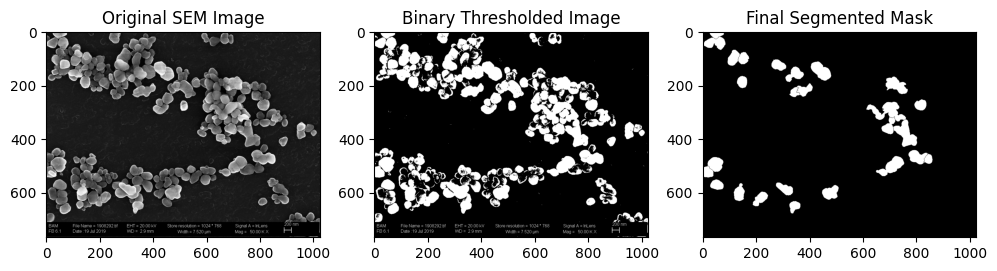

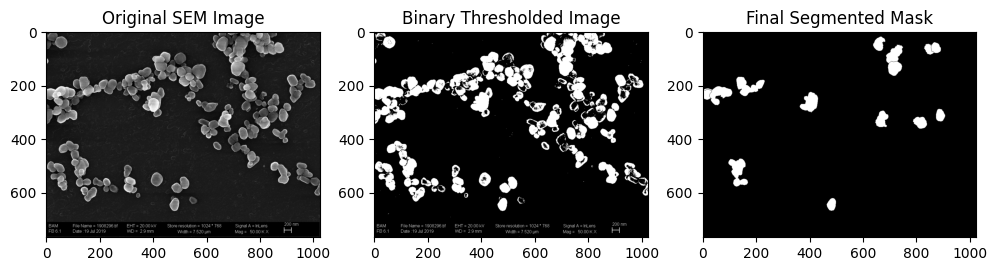

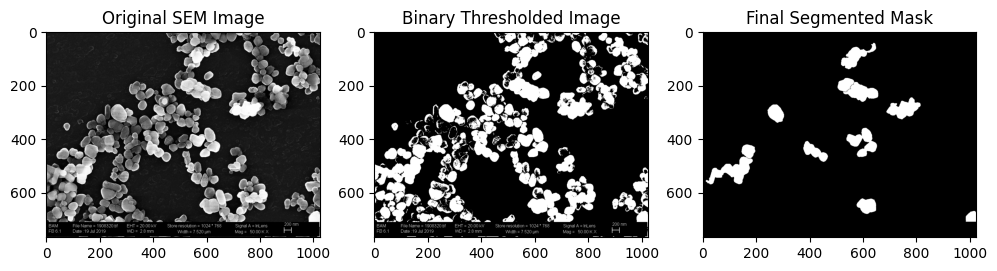

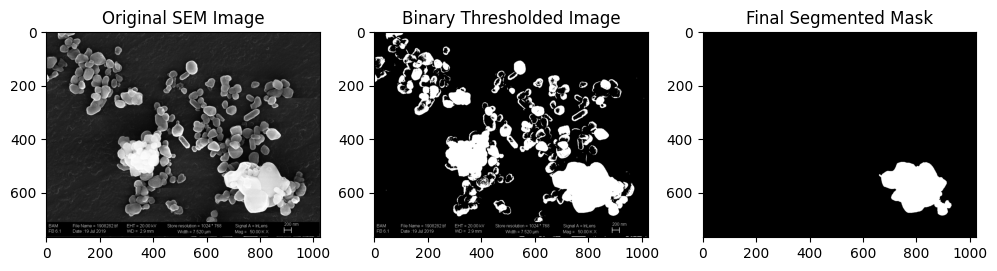

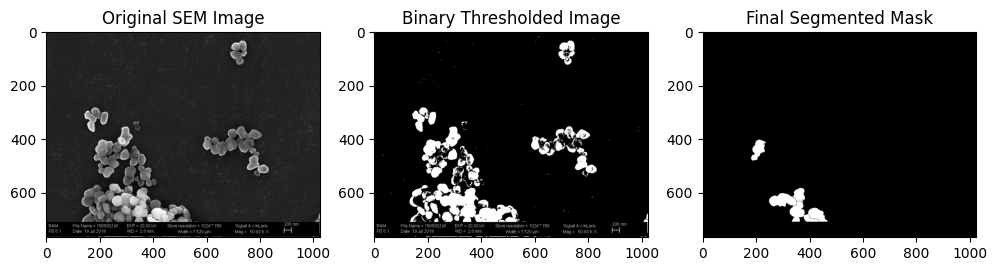

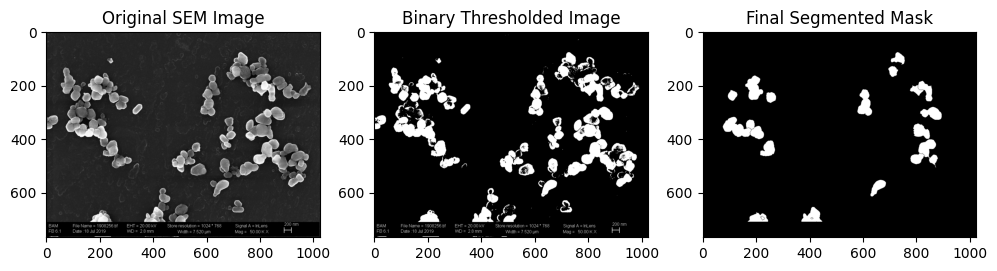

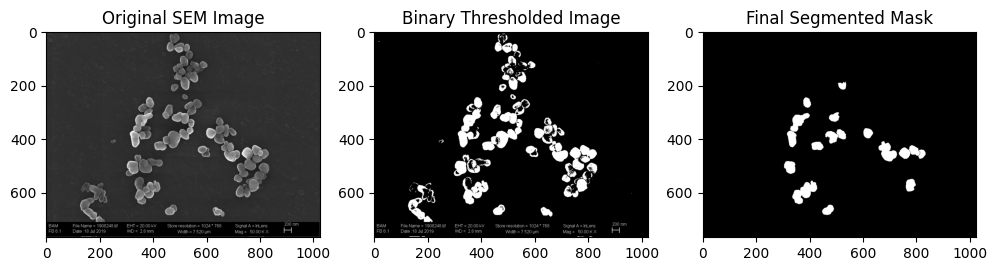

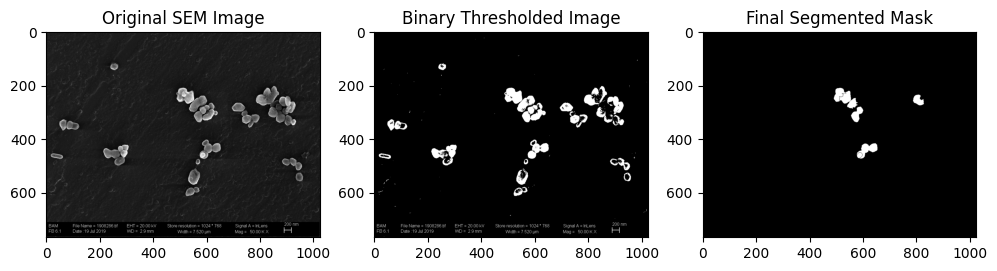

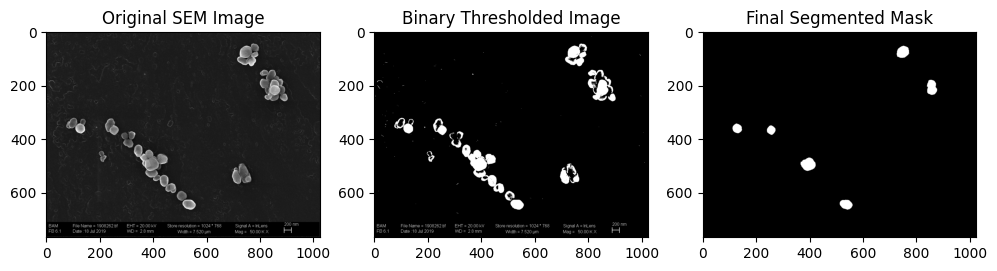

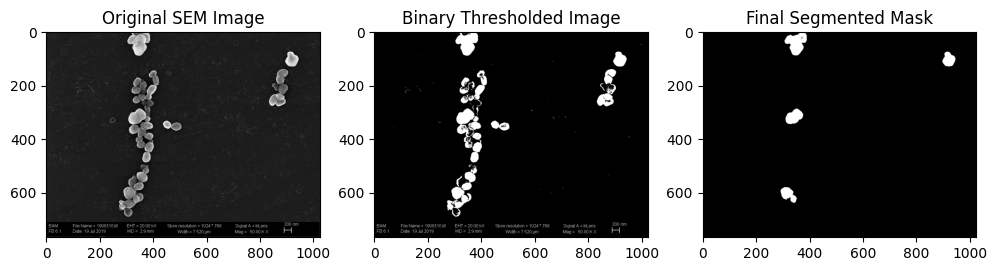

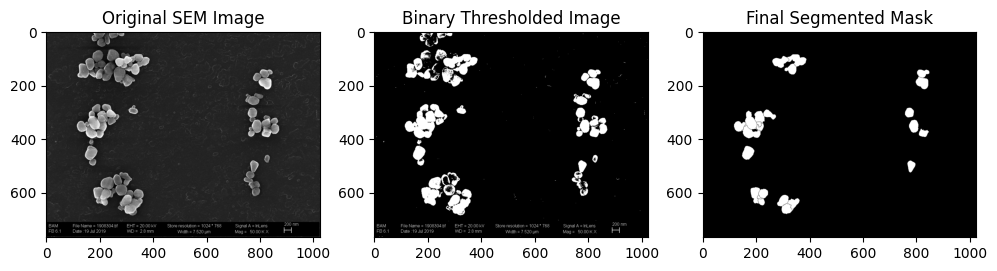

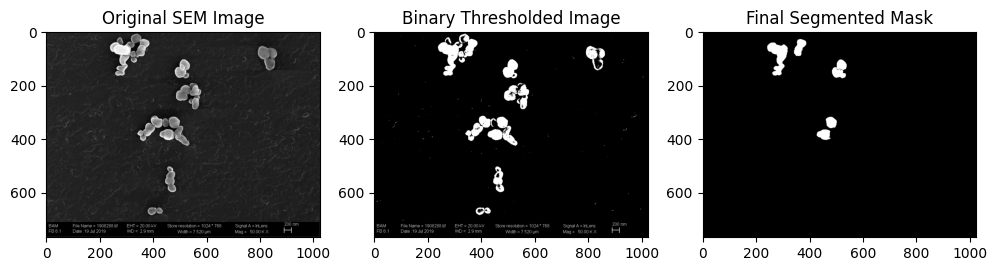

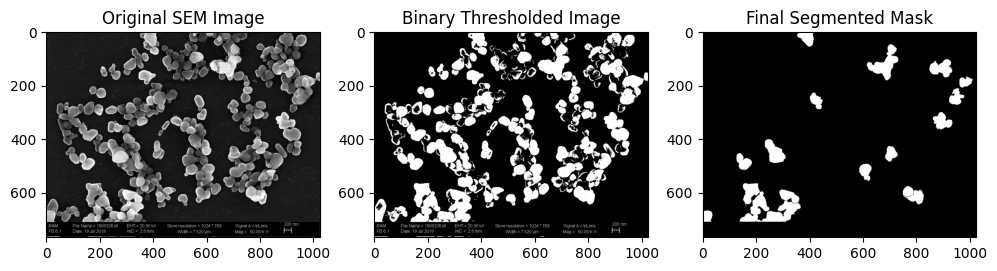

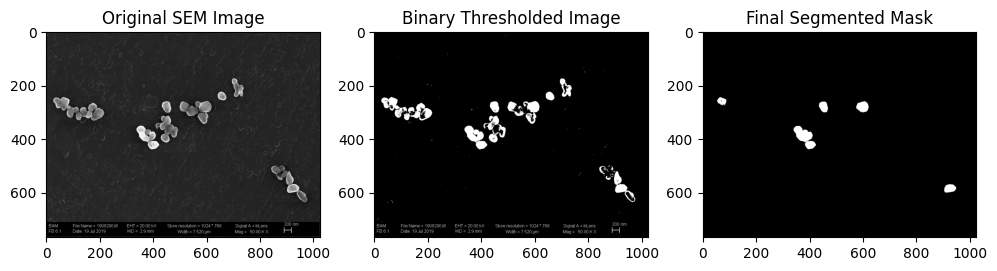

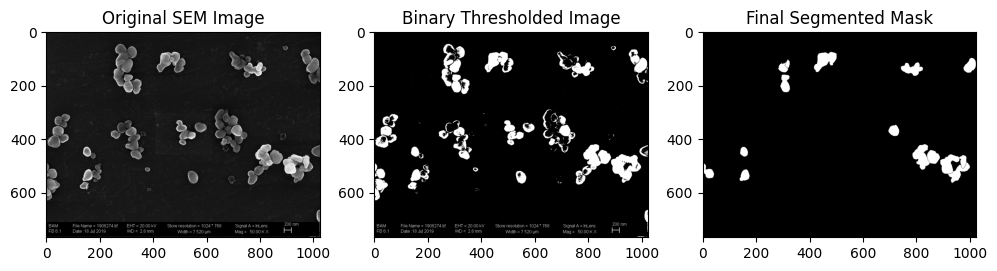

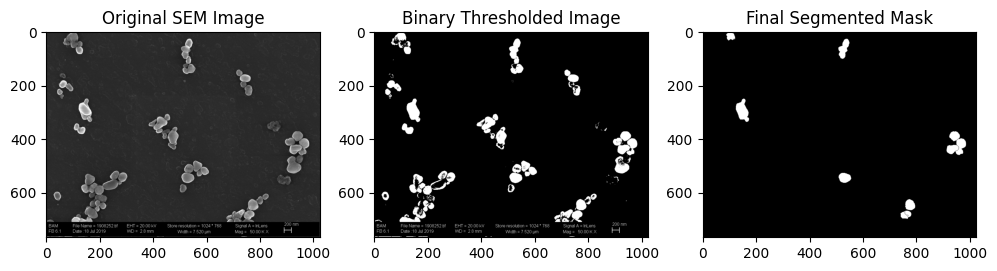

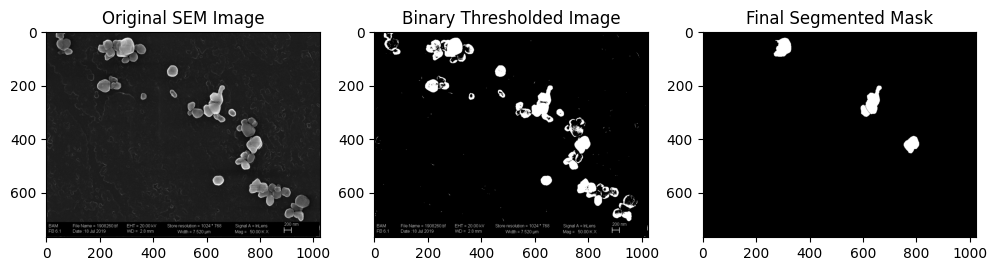

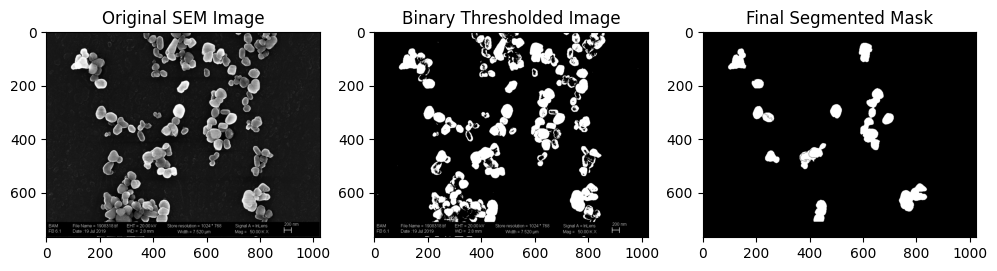

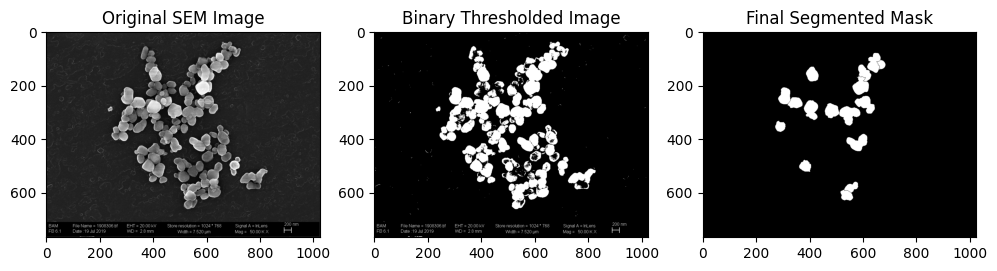

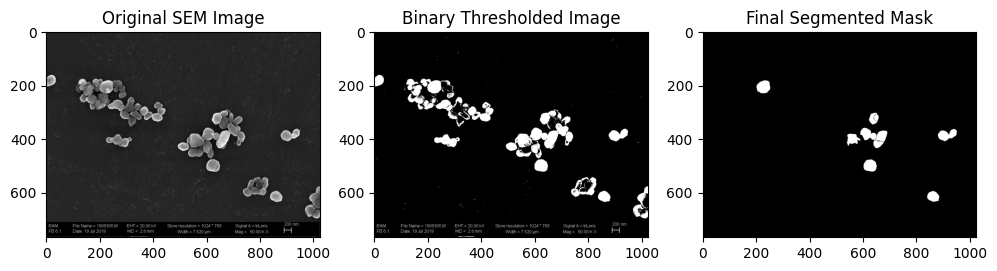

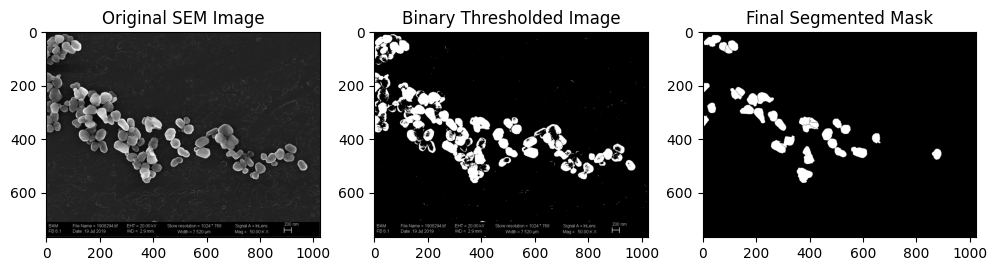

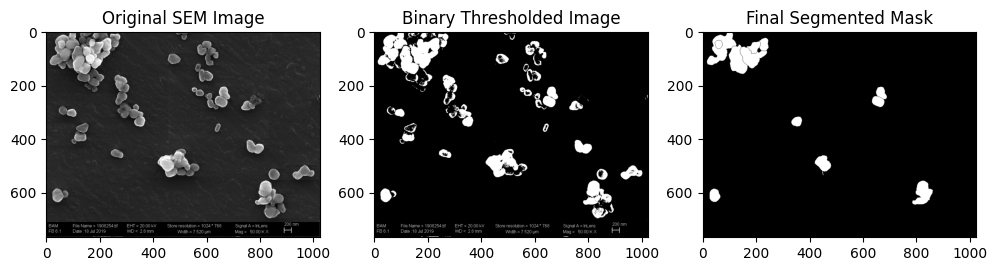

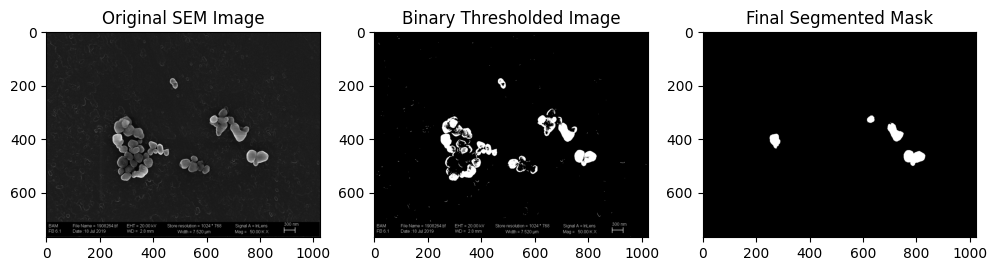

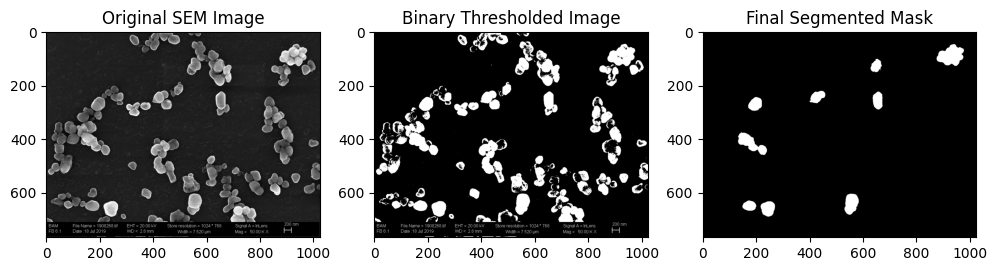

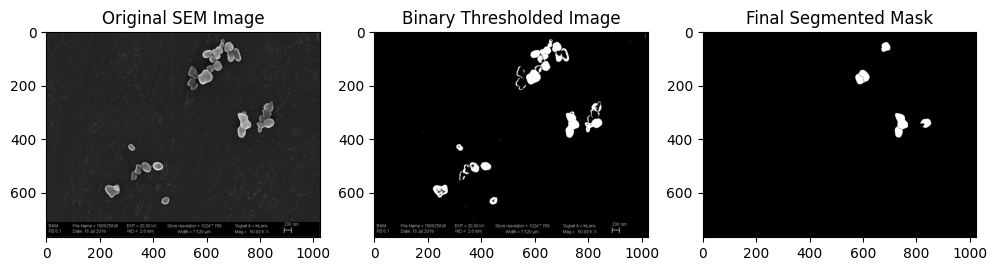

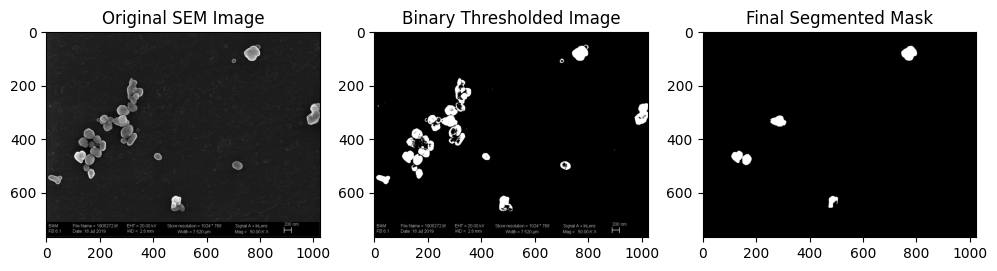

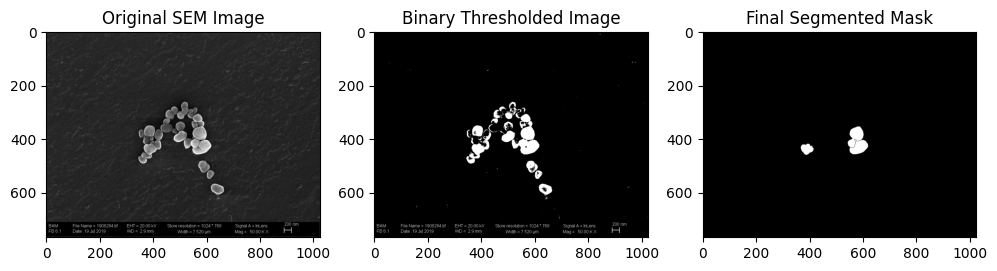

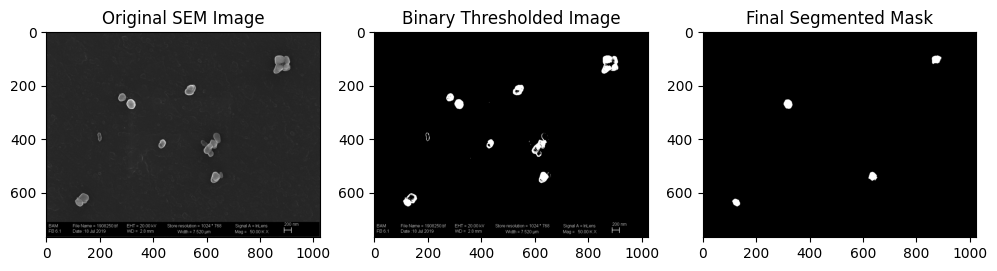

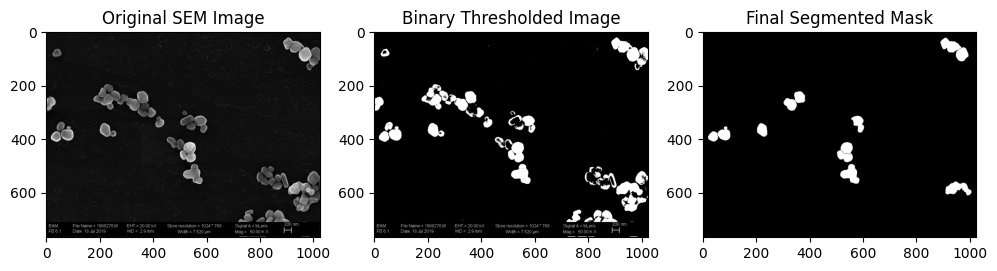

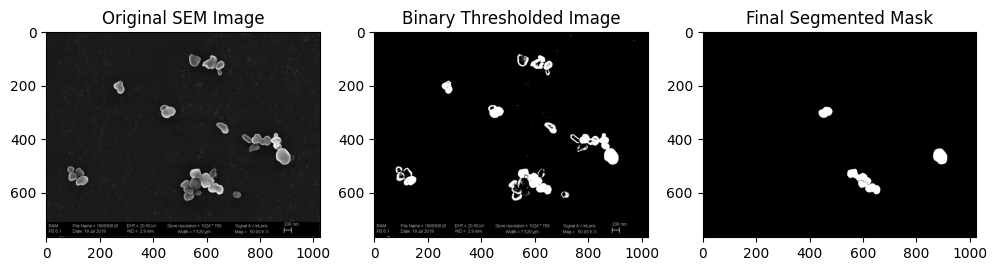

Watershed segmentation complete. Masks saved in: dataset/SEM_masks


In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Create output directory for saving masks
input_dir = "/content/SEM_images/SEM"  # Folder containing SEM images
output_dir = "dataset/SEM_masks"
os.makedirs(output_dir, exist_ok=True)

# Loop through all images in the input directory
for file in os.listdir(input_dir):
    # Load SEM image in grayscale
    img_path = os.path.join(input_dir, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Step 1: Apply Otsu's Thresholding to create binary image
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step 2: Noise Removal using Morphological Opening
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Step 3: Sure Background Area (Dilation)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Step 4: Sure Foreground Area using Distance Transform
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Step 5: Identifying Unknown Region (Subtracting Foreground from Background)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Step 6: Label Markers for Watershed
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1  # Ensure background is labeled as 1
    markers[unknown == 255] = 0  # Mark unknown regions with 0

    # Step 7: Convert Grayscale to Color (For Watershed Algorithm)
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Step 8: Apply Watershed Algorithm
    markers = cv2.watershed(img_color, markers)

    # Step 9: Generate Final Mask
    mask = np.where(markers > 1, 255, 0).astype(np.uint8)  # Keep only segmented objects

    # Save the mask
    cv2.imwrite(os.path.join(output_dir, file), mask)

    # Optional: Display results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original SEM Image")
    plt.subplot(1, 3, 2)
    plt.imshow(binary, cmap='gray')
    plt.title("Binary Thresholded Image")
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title("Final Segmented Mask")
    plt.show()

print("Watershed segmentation complete. Masks saved in:", output_dir)
